# 䁖一眼MNIST数据

In [1]:
import os
from sklearn.datasets import fetch_openml
data_path = os.path.join(os.getcwd(),'scikit_learn_data')
mnist = fetch_openml('mnist_784',version=1,data_home=data_path)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X = mnist["data"]
y = mnist["target"]
## X是一个矩阵，70000×784的，70000表示70000张图片，每张图片784个特征，这个特征数是 28×28 像素然后拼成一列来的
## y就是一个向量，70000个标签表示这张图片上的数字是多少
X = X.to_numpy()

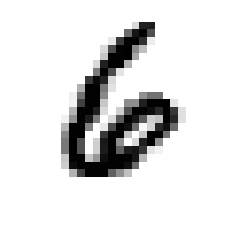

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# 取一张图片看看
some_digit = X[13]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation="nearest") # 采取最近邻插值
plt.axis("off")
plt.show()

In [7]:
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]
y = y.astype(np.uint8) # 将所有字符串的标签转化为数字

# 做一个Binary的分类器(二分类器)

In [ ]:
# 这里我们做一个能识别是否是6的识别器

In [13]:
# 注意这里需要用binary的标签去训练
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)
# 选择用sklearn的随机梯度下降分类器(SGD)来进行训练
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_6) # 只用关于6的binary的标签来训练仅能识别6的分类器
sgd_clf.predict([some_digit]) # []将输入参数变化为2维的

array([ True])

In [ ]:
# 我们接着想要评估一下这个分类器的表现能力，在此之前需要看看如何衡量表现能力

# Performance Measures

#### 使用Accuracy来作为Performance Measures

In [16]:
#### 这里的Accuracy一般从交叉验证中算出来
#### 先手写实现一波交叉验证
#################################### Manual Cross Validation ###########################################
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 先对训练集数据进行分层然后再划分Folds
# 分层使得划分出的Folds中每个类别的待识别样本的比例基本一致
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle=True) # 划分成三家 train/test 集

for train_index, test_index in skfolds.split(X_train,y_train_6): # 用上面定义的模式去分 X_train集和y_train_6集
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_6_fold = y_train_6[train_index] ## 这两个用于训练
    X_test_fold = X_train[test_index]  ## 这个用于预测
    y_test_6_fold = y_train_6[test_index]  ## 这个用于对比预测结果
    
    clone_clf.fit(X_train_fold,y_train_6_fold)
    y_predictions = clone_clf.predict(X_test_fold)
    n_accurate = sum(y_test_6_fold == y_predictions)
    print(n_accurate/len(y_predictions))
    
########################################################################################################

0.94635
0.98085
0.98335


In [19]:
## 以上都是手动的，下面是sklearn提供给我们的
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_6,cv=3,scoring="accuracy") # 声明采用accuracy的方式来计算测试/验证的分数

array([0.9829 , 0.98025, 0.9804 ])

In [20]:
## 这个准确率就离谱吧，让我们来看看一个摆烂分类器(判断不是6的分类器)
from sklearn.base import BaseEstimator
class BaiLanClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X,y=None):
        return np.zeros((len(X),1),dtype=bool)
bailan_clf = BaiLanClassifier()
cross_val_score(bailan_clf,X_train,y_train_6,scoring="accuracy")

array([0.89933333, 0.90316667, 0.90025   , 0.90158333, 0.9025    ])

In [ ]:
## 就这摆烂的都能上90%的准确率
## 因为整个训练集中只有差不多10%的6，而有差不多90%的不是6，因此就算判断是6的准确率不高，另一方面判断不是6的准确率那也会相当高的
## 这么看来，准确率虽然在衡量判断一些类别时的结果令人激动，但是在衡量判断另一些类别时的结果却有点离谱
## 所以准确率并不是一种很好的用来衡量分类效果的指标，那下面看看混淆矩阵怎么样(Confusion Matrix)

#### Confusion Matrix(混淆矩阵)

In [22]:
## 混淆矩阵的思想就是 统计A类实例被归类为B类的次数
## 混淆矩阵的出现会牵涉到后面 Precision和 Recall概念的出现
## 一个混淆矩阵需要多组预测的结果
from sklearn.model_selection import cross_val_predict
# cross_val_predict 也会进行交叉验证的分fold的操作，但是它在分出fold，决定哪些是train_fold，哪些是test_fold后
# 会用train_fold训练模型，用test_fold喂给模型得出predictions
y_trained_pred = cross_val_predict(sgd_clf,X_train,y_train_6,cv = 3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6,y_trained_pred)

array([[53562,   520],
       [  609,  5309]], dtype=int64)

In [ ]:
# 这个就是混淆矩阵了
# 对于这个二分类问题，第一行是Negative(非6)类，第二行是Positive(6)类，是Actual的
# 第一列是预测的Negative，第二列是预测的Positive
# 第一个数字表示本来是Neg的预测还是为Neg，是True Negative(TN)
# 第二个数字表示本来是Neg的预测却是为Pos, 是False Positive(FP)
# 第三个数字表示本来是Pos的预测却是为Neg, 是False Negative(FN)
# 第四个数字表示本来是Pos的预测还是为Pos, 是True Positive(TP)
## 接下来介绍Precision和Recall的计算方法和具体含义

#### Precision & Recall